In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from vit_tensorflow.ViT import ViT


# Enable eager execution
tf.config.experimental_run_functions_eagerly(True)

import matplotlib.pyplot as plt
import numpy as np
import os
import random

from PIL import Image
from pathlib import Path
from transformers import AutoFeatureExtractor, TFAutoModelForImageClassification, ViTImageProcessor
from datasets import load_dataset



In [24]:
import vit_tensorflow.ViT
print(dir(vit_tensorflow.ViT))


['Attention', 'Layer', 'MLP', 'Model', 'PreNorm', 'Rearrange', 'Sequential', 'Transformer', 'ViT', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'einsum', 'nn', 'pair', 'rearrange', 'repeat', 'tf']


In [2]:
# Load your data
data_dir = 'C:\\Users\\franc\\Documents\\GitHub\\Car_Detection_Chat\\testando'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=64
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=64
)


Found 6553 files belonging to 66 classes.
Using 5243 files for training.


c:\Users\franc\Documents\Data_Science\Anaconda_Navigator\envs\law_chat\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 6553 files belonging to 66 classes.
Using 1310 files for validation.


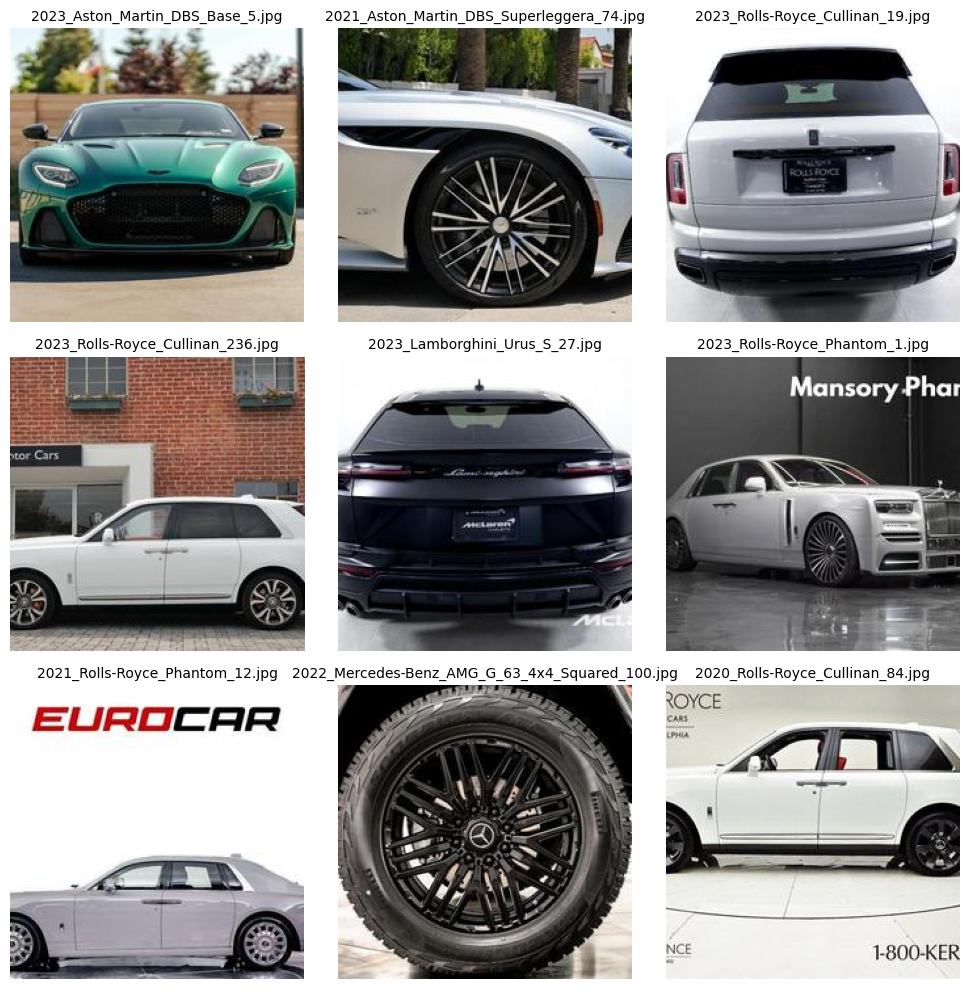

In [3]:
data_dir_object = Path('C:\\Users\\franc\\Documents\\GitHub\\Car_Detection_Chat\\testando')  


# Fetch all images from the dataset
all_images = list(data_dir_object.glob('**/*.jpg'))  # assuming all images are jpg. You can adjust the pattern accordingly.

# Sample 9 random images
random_images = random.sample(all_images, 9)

# Display the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax, img_path in zip(axes.ravel(), random_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.name, fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:

# # Verify problems wtht the files

# for root, dirs, files in os.walk(data_dir):
#     for file in files:
#         if file.lower().endswith(('.png', '.jpg', '.jpeg')):
#             file_path = os.path.join(root, file)
#             try:
#                 with Image.open(file_path) as img:
#                     img.verify()
#             except Exception as e:
#                 print(f"Problem with file: {file_path}. Error: {e}")


In [ ]:
# # CHECK ENCODING
# def check_utf8_encoding(data_dir):
#     for root, dirs, files in os.walk(data_dir):
#         # # Check directory names
#         # for dir_name in dirs:
#         #     try:
#         #         dir_name.decode('utf-8')
#         #     except UnicodeDecodeError:
#         #         print(f"Non-UTF-8 directory name detected: {os.path.join(root, dir_name)}")
        
#         # Check file names
#         for file_name in files:
#             try:
#                 file_name.encode('utf-8').decode('utf-8')
#             except UnicodeDecodeError:
#                 print(f"Non-UTF-8 file name detected: {os.path.join(root, file_name)}")

# data_dir = 'C:\\Users\\franc\\Documents\\GitHub\\Car_Detection_Chat\\images_backup'
# check_utf8_encoding(data_dir)

In [4]:
def normalize_image(img, label):
    img = img / 255.0
    return img, label

train_ds = train_ds.map(normalize_image)
val_ds = val_ds.map(normalize_image)


In [5]:
sample_img, sample_label = next(iter(train_ds.take(1)))
print("Min Value:", tf.reduce_min(sample_img).numpy())
print("Max Value:", tf.reduce_max(sample_img).numpy())


Min Value: 0.0
Max Value: 1.0


In [7]:
# # Load the pre-trained ViT model and feature extractor
# extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
# model = TFAutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")


All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [26]:
model = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 768,          # You might need to adjust this according to the model's configuration
    depth = 12,         # Adjust as per your requirement
    heads = 12,         # Adjust as per your requirement
    mlp_dim = 3072,     # Adjust as per your requirement
    dropout = 0.1,
    emb_dropout = 0.1
)


In [27]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),  # Rotates the image up to a fraction of 0.1 of 360 degrees
    layers.experimental.preprocessing.RandomZoom(0.2),      # Randomly zooms the image up to 20%
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),  # Randomly translates the image up to 10% horizontally and vertically
    # Add more augmentation layers if needed
])


In [28]:
@tf.function

def prepare_data(images, labels, training=True):
    # Apply augmentation only if it's training
    if training:
        images = data_augmentation(images, training=True)

    # Then proceed with the rest of the preprocessing
    images_np = images.numpy()
    # Clip values just to be sure they're between 0 and 1
    images_np = np.clip(images_np, 0, 1)
    
    inputs = extractor(images_np, return_tensors="tf")
    return inputs["pixel_values"], labels

In [29]:
train_ds = train_ds.map(lambda x, y: tf.py_function(prepare_data, [x, y], [tf.float32, tf.int32]))
val_ds = val_ds.map(lambda x, y: tf.py_function(prepare_data, [x, y], [tf.float32, tf.int32]))

c:\Users\franc\Documents\Data_Science\Anaconda_Navigator\envs\law_chat\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [35]:
# Remove the classification head
base_model = model

# Define the input layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

# Pass the input through the base model
features = base_model(input_layer)

# Create a new top layer (classifier) for your specific number of classes
num_classes = 66  # Replace with your actual number of classes
output = tf.keras.layers.Dense(num_classes, activation='softmax')(features)

# Connect the new classifier to the base model
output = classifier(base_model.output)

# Formulate the new model
fine_tuned_model = tf.keras.models.Model(inputs=base_model.input, outputs=output)



TypeError: Exception encountered when calling layer "vi_t" (type ViT).

in user code:

    File "c:\Users\franc\Documents\GitHub\Car_Detection_Chat\vit_tensorflow\ViT.py", line 163, in call  *
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
    File "c:\Users\franc\Documents\Data_Science\Anaconda_Navigator\envs\law_chat\lib\site-packages\einops\einops.py", line 641, in repeat  *
        return reduce(tensor, pattern, reduction="repeat", **axes_lengths)
    File "c:\Users\franc\Documents\Data_Science\Anaconda_Navigator\envs\law_chat\lib\site-packages\einops\einops.py", line 524, in reduce  *
        backend, recipe, cast(Tensor, tensor), reduction_type=reduction, axes_lengths=hashable_axes_lengths
    File "c:\Users\franc\Documents\Data_Science\Anaconda_Navigator\envs\law_chat\lib\site-packages\einops\einops.py", line 239, in _apply_recipe  *
        _result = _reconstruct_from_shape_uncached(recipe, backend.shape(tensor), axes_lengths)
    File "c:\Users\franc\Documents\Data_Science\Anaconda_Navigator\envs\law_chat\lib\site-packages\einops\einops.py", line 205, in _reconstruct_from_shape_uncached  *
        final_shapes.append(_product(lengths))
    File "c:\Users\franc\Documents\Data_Science\Anaconda_Navigator\envs\law_chat\lib\site-packages\einops\einops.py", line 32, in _product  *
        result *= element

    TypeError: unsupported operand type(s) for *=: 'int' and 'NoneType'


Call arguments received by layer "vi_t" (type ViT):
  • img=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • kwargs=<class 'inspect._empty'>